In [ ]:
#Read Me:
#1. Ran correlation- Continuous variables and categorical variables
# From Model selection- Fjob and Guardian were not included in the Model
# Response variables G3- Outlier, Score below 5 were excluded and the distribution was normal distributed
# Multivariate linear Regression-At 95% CI and 0.05 significance- School,G1 G2, AGE, sex, HIGHER, absences, Travel time, failures, school sup were boaderline significant so was added in the model, so ran again with these selected model.

# The models were ran separately for both schools independently with these predictors.
# Sex difference between two schools were observed.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import sys
import os
sys.path.append(os.path.abspath("utils/variables.py"))
#from utils.variables.py import bin_vars, ord_vars, cont_vars, cat_vars, numeric_vars, nom_vars
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.stats import lognorm, shapiro, norm
from scipy.stats import pointbiserialr, f_oneway
from scipy.stats import pointbiserialr
from statsmodels.formula.api import ols
from scipy import stats
from io import StringIO
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import pointbiserialr


In [4]:
url = "https://raw.githubusercontent.com/seanmcgowanx/aai-500-final-project-team-5/origin/deepika-correlation-analysis/data/student_preprocessed.csv"
student_df = pd.read_csv(url)
# Display first few rows
print(student_df.head())
# (Optional) Display info about the dataset
student_df.info()
print(student_df.shape)
print(student_df.head())
print(student_df.columns.tolist())
student_df.columns
summerize = student_df.describe()
print(summerize)


   school  sex  age  address  famsize  Pstatus  Medu  Fedu     Mjob      Fjob  \
0       1    0   18        1        1        0     4     4  at_home   teacher   
1       1    0   17        1        1        1     1     1  at_home     other   
2       1    0   15        1        0        1     1     1  at_home     other   
3       1    0   15        1        1        1     4     2   health  services   
4       1    0   16        1        1        1     3     3    other     other   

   ... famrel freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  
0  ...      4        3      4     1     1       3         4   0  11  11  
1  ...      5        3      3     1     1       3         2   9  11  11  
2  ...      4        3      2     2     3       3         6  12  13  12  
3  ...      3        2      2     1     1       5         0  14  14  14  
4  ...      4        3      2     1     2       5         0  11  13  13  

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

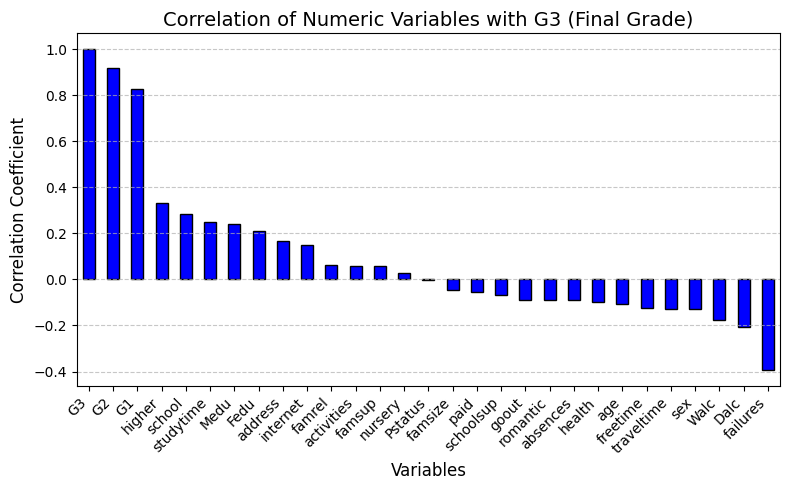

In [ ]:
# Run correlation analysis (quantitative features vs grades).
# Select numeric columns
numeric_df = student_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Extract correlations with G3
corr_with_G3 = corr_matrix['G3'].sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
corr_with_G3.plot(kind='bar', color='blue', edgecolor='black')

plt.title('Correlation of Numeric Variables with G3 (Final Grade)', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Variables', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [ ]:
# Identify categorical variables
categorical_cols = student_df.select_dtypes(include=['object']).columns

results = []

for col in categorical_cols:
    unique_vals = student_df[col].dropna().unique()

    # Binary variable → Point-biserial correlation
    if len(unique_vals) == 2:
        mapping = {val: i for i, val in enumerate(unique_vals)}
        student_df[f"{col}_num"] = student_df[col].map(mapping)
        corr, pval = pointbiserialr(df[f"{col}_num"], df['G3'])
        results.append({'Variable': col, 'Type': 'Binary', 'Correlation': corr, 'p-value': pval})

    # Multi-category variable → Eta-squared (effect size from ANOVA)
    elif len(unique_vals) > 2:
        groups = [student_df.loc[student_df[col] == val, 'G3'].dropna() for val in unique_vals]
        f_stat, pval = f_oneway(*groups)
        # Compute eta-squared
        ss_between = sum(len(g) * (g.mean() - student_df['G3'].mean())**2 for g in groups)
        ss_total = sum((student_df['G3'] - student_df['G3'].mean())**2)
        eta_sq = ss_between / ss_total if ss_total != 0 else np.nan
        results.append({'Variable': col, 'Type': 'Categorical', 'Correlation': eta_sq, 'p-value': pval})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by absolute strength of correlation
results_df['|Correlation|'] = results_df['Correlation'].abs()
results_df = results_df.sort_values(by='|Correlation|', ascending=False)

print("📊 Strength of association between categorical variables and G3:")
print(results_df[['Variable', 'Type', 'Correlation', 'p-value']])


📊 Strength of association between categorical variables and G3:
   Variable         Type  Correlation   p-value
2    reason  Categorical     0.045498  0.000001
0      Mjob  Categorical     0.043774  0.000008
1      Fjob  Categorical     0.019922  0.011376
3  guardian  Categorical     0.008102  0.072262


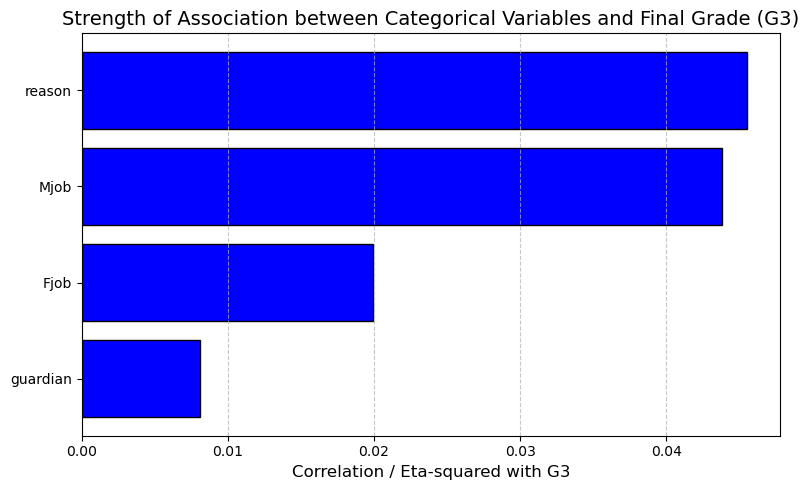

In [ ]:

# --- Visualization ---
plt.figure(figsize=(8, 5))
plt.barh(results_df['Variable'], results_df['Correlation'], color='blue', edgecolor='black')
plt.xlabel('Correlation / Eta-squared with G3', fontsize=12)
plt.title('Strength of Association between Categorical Variables and Final Grade (G3)', fontsize=14)
plt.gca().invert_yaxis()  # Highest correlation on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

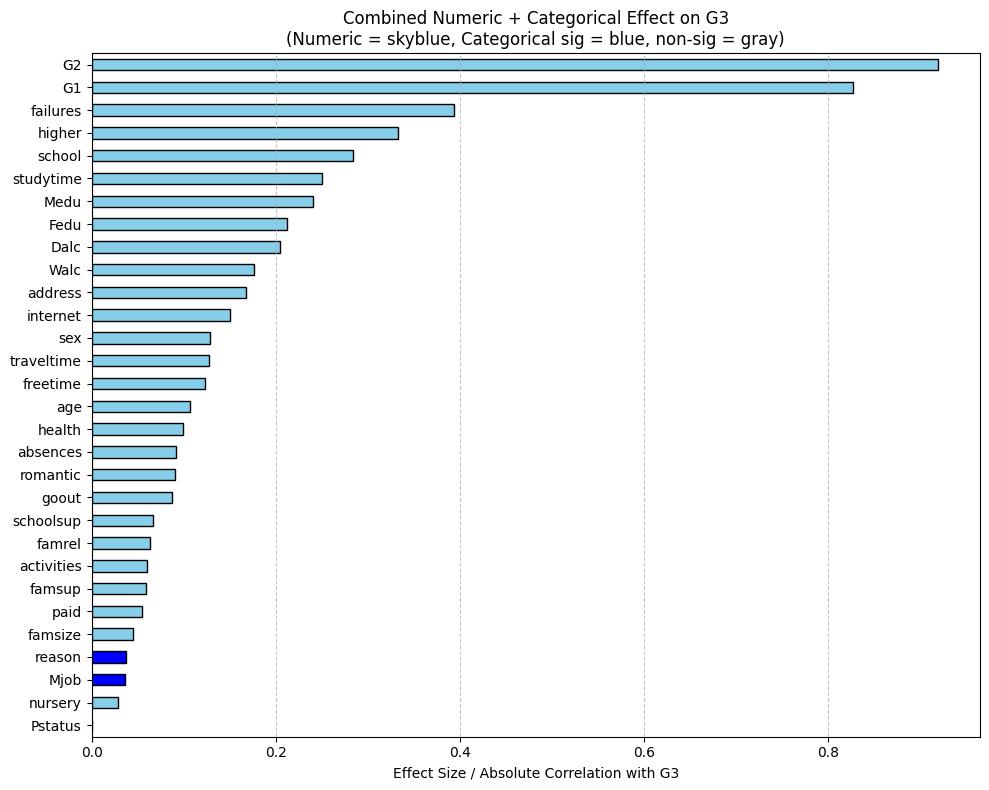

In [ ]:
# ----------------------------
# 1️⃣ Numeric variables: Pearson correlation with G3
# ----------------------------
numeric_cols = student_df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('G3')  # exclude target

numeric_corr = student_df[numeric_cols + ['G3']].corr()['G3'].drop('G3')
numeric_corr = numeric_corr.abs()  # take absolute value for ranking

# ----------------------------
# 2️⃣ Categorical variables: Stepwise ANOVA + Eta-squared
# ----------------------------
categorical_cols = student_df.select_dtypes(include=['object']).columns.tolist()

# Stepwise ANOVA selection
selected_vars = []
remaining_vars = categorical_cols.copy()
alpha_enter = 0.05
alpha_remove = 0.10
improved = True

while improved:
    improved = False

    # Forward
    forward_pvals = {}
    for var in remaining_vars:
        formula = f"G3 ~ {' + '.join(selected_vars + [var])}" if selected_vars else f"G3 ~ {var}"
        model = ols(formula, data=student_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        forward_pvals[var] = anova_table.loc[var, 'PR(>F)']

    if forward_pvals:
        best_var = min(forward_pvals, key=forward_pvals.get)
        if forward_pvals[best_var] < alpha_enter:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
            improved = True

    # Backward
    if selected_vars:
        formula = f"G3 ~ {' + '.join(selected_vars)}"
        model = ols(formula, data=student_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        for var in selected_vars.copy():
            pval = anova_table.loc[var, 'PR(>F)']
            if pval > alpha_remove:
                selected_vars.remove(var)
                remaining_vars.append(var)
                improved = True

# Final ANOVA model
final_formula = f"G3 ~ {' + '.join(selected_vars)}"
final_model = ols(final_formula, data=student_df).fit()
anova_table = sm.stats.anova_lm(final_model, typ=2)

# Eta-squared for categorical variables
eta_squared = anova_table['sum_sq'] / sum(anova_table['sum_sq'])
eta_squared = eta_squared.drop('Residual')
categorical_effects = eta_squared.abs()

# ----------------------------
# 3️⃣ Combine numeric + categorical
# ----------------------------
combined = pd.concat([numeric_corr, categorical_effects])
combined = combined.sort_values(ascending=True)  # ascending for horizontal bar chart

# Colors: numeric = skyblue, categorical significant = blue, categorical non-sig = gray
colors = []
for var in combined.index:
    if var in numeric_corr.index:
        colors.append('skyblue')
    else:
        pval = anova_table.loc[var, 'PR(>F)']
        colors.append('blue' if pval < 0.05 else 'lightgray')

# ----------------------------
# 4️⃣ Plot
# ----------------------------
plt.figure(figsize=(10, 8))
combined.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Effect Size / Absolute Correlation with G3')
plt.title('Combined Numeric + Categorical Effect on G3\n(Numeric = skyblue, Categorical sig = blue, non-sig = gray)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

(633, 33)
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
           school         sex         age     address     famsize     Pstatus  \
count  633.000000  633.000000  633.000000  633.000000  633.000000  633.000000   
mean     0.665087    0.406003   16.720379    0.704581    0.699842    0.876777   
std      0.472333    0.491473    1.214044    0.456592    0.458689    0.328953   
min      0.000000    0.000000   15.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000   16.000000    0.000000    0.000000    1.000000   
50%      1.000000    0.000000   17.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000   18.000000    1.000000    1.000000    1.000000   
max      1.000

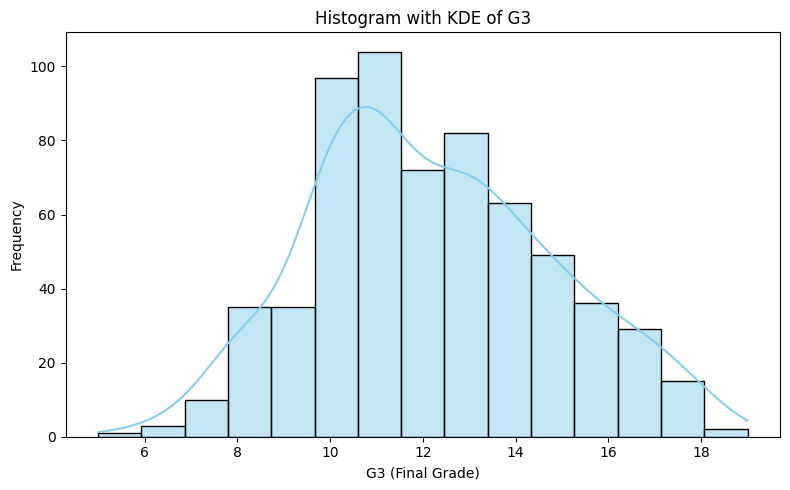

Model formula: G3 ~ age + studytime + absences + G1 + G2 + traveltime + studytime + failures + schoolsup + famsup + paid + activities + nursery + higher + internet + romantic + famrel + freetime + goout + Dalc + Walc + health + C(school) + C(sex) + C(address) + C(famsize) + C(Mjob) + C(reason)
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     180.6
Date:                Tue, 14 Oct 2025   Prob (F-statistic):  

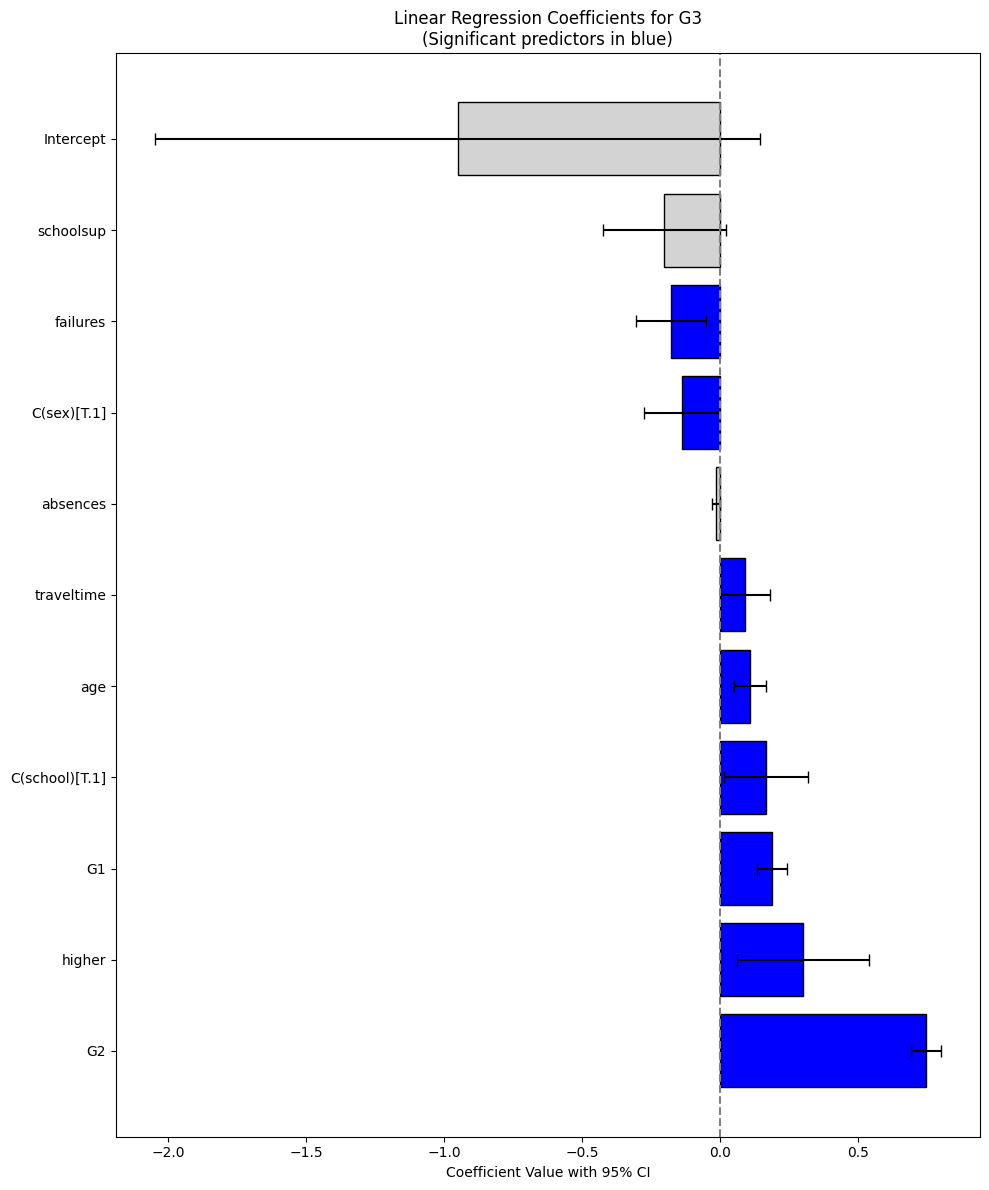

In [6]:
# As discussed; we can remove outliers in the response variables and then run linear regression
# Remove Outliers

# 3) Remove the outlier Grade score <5

df_subset = student_df[(student_df['G3'] >=5)]

print(df_subset.shape)
print(df_subset.columns.tolist())
summerize = df_subset.describe()
print(summerize)


# 2. Distributions & Skewness of Continuous Variables
plt.figure(figsize=(8, 5))
sns.histplot(df_subset['G3'], kde=True, bins=15, color='skyblue', edgecolor='black')
plt.title('Histogram with KDE of G3')
plt.xlabel('G3 (Final Grade)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#=======================Running the linear model with full selected predictor variables =================================================

categorical_vars = ['school', 'sex', 'address', 'famsize', 'Mjob', 'reason']
continuous_vars = ['age', 'studytime', 'absences', 'G1', 'G2',  'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health'
]

formula = 'G3 ~ ' + ' + '.join(continuous_vars + [f'C({var})' for var in categorical_vars])
print("Model formula:", formula)

print(df_subset.columns.tolist())

model = smf.ols(formula=formula, data=df_subset).fit()
print(model.summary())

#========================================= Adjusting some selected significant variables & known predictors ===================================

categorical_vars = ['school','sex']
continuous_vars = ['G1', 'G2', 'age', 'traveltime', 'failures', 'absences', 'higher', 'schoolsup', ]

formula1 = 'G3 ~ ' + ' + '.join(continuous_vars + [f'C({var})' for var in categorical_vars])
print("Model formula:", formula1)

model1 = smf.ols(formula=formula1, data=df_subset).fit()
print(model1.summary())


# Coefficients with 95% confidence intervals
conf_int = model1.conf_int()
conf_int.columns = ['CI_lower', 'CI_upper']
coef_df = conf_int.copy()
coef_df['coef'] = model1.params
coef_df = coef_df.sort_values(by='coef', ascending=False)
print("\nCoefficients with 95% CI:")
print(coef_df)
# Model performance metrics
from sklearn.metrics import mean_squared_error, r2_score

# Define X and y based on the formula for model1
y = df_subset['G3']

y_pred = model1.predict(df_subset)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.3f}")
#====================================================================

# Determine colors based on the sign of the coefficients
colors = ['blue' if (model1.pvalues[i] < 0.05) else 'lightgray' for i in coef_df.index]

plt.figure(figsize=(10, 12))
plt.barh(coef_df.index, coef_df['coef'],
         xerr=[coef_df['coef'] - coef_df['CI_lower'], coef_df['CI_upper'] - coef_df['coef']],
         color=colors, edgecolor='black', capsize=4)
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value with 95% CI')
plt.title('Linear Regression Coefficients for G3\n(Significant predictors in blue)')
plt.tight_layout()
plt.show()


# Next step : May be : We can look restriting by each school

(421, 33)
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
       school         sex         age     address     famsize     Pstatus  \
count   421.0  421.000000  421.000000  421.000000  421.000000  421.000000   
mean      1.0    0.437055   16.665083    0.814727    0.712589    0.869359   
std       0.0    0.496612    1.245732    0.388981    0.453093    0.337409   
min       1.0    0.000000   15.000000    0.000000    0.000000    0.000000   
25%       1.0    0.000000   16.000000    1.000000    0.000000    1.000000   
50%       1.0    0.000000   17.000000    1.000000    1.000000    1.000000   
75%       1.0    1.000000   18.000000    1.000000    1.000000    1.000000   
max       1.0    1.000000   22.000000    1.000

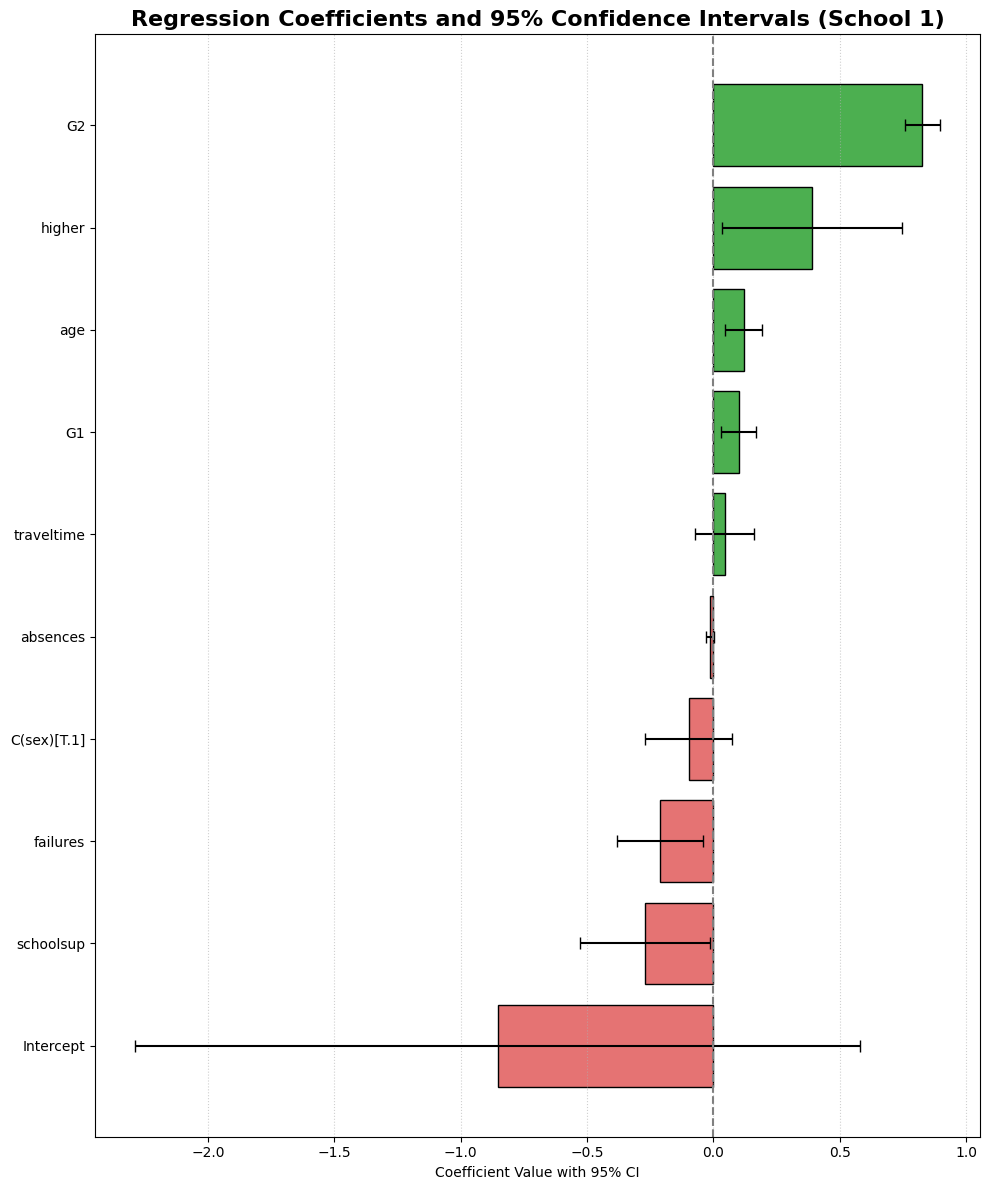

(212, 33)
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
       school         sex         age     address     famsize     Pstatus  \
count   212.0  212.000000  212.000000  212.000000  212.000000  212.000000   
mean      0.0    0.344340   16.830189    0.485849    0.674528    0.891509   
std       0.0    0.476277    1.143469    0.500983    0.469660    0.311735   
min       0.0    0.000000   15.000000    0.000000    0.000000    0.000000   
25%       0.0    0.000000   16.000000    0.000000    0.000000    1.000000   
50%       0.0    0.000000   17.000000    0.000000    1.000000    1.000000   
75%       0.0    1.000000   18.000000    1.000000    1.000000    1.000000   
max       0.0    1.000000   20.000000    1.000

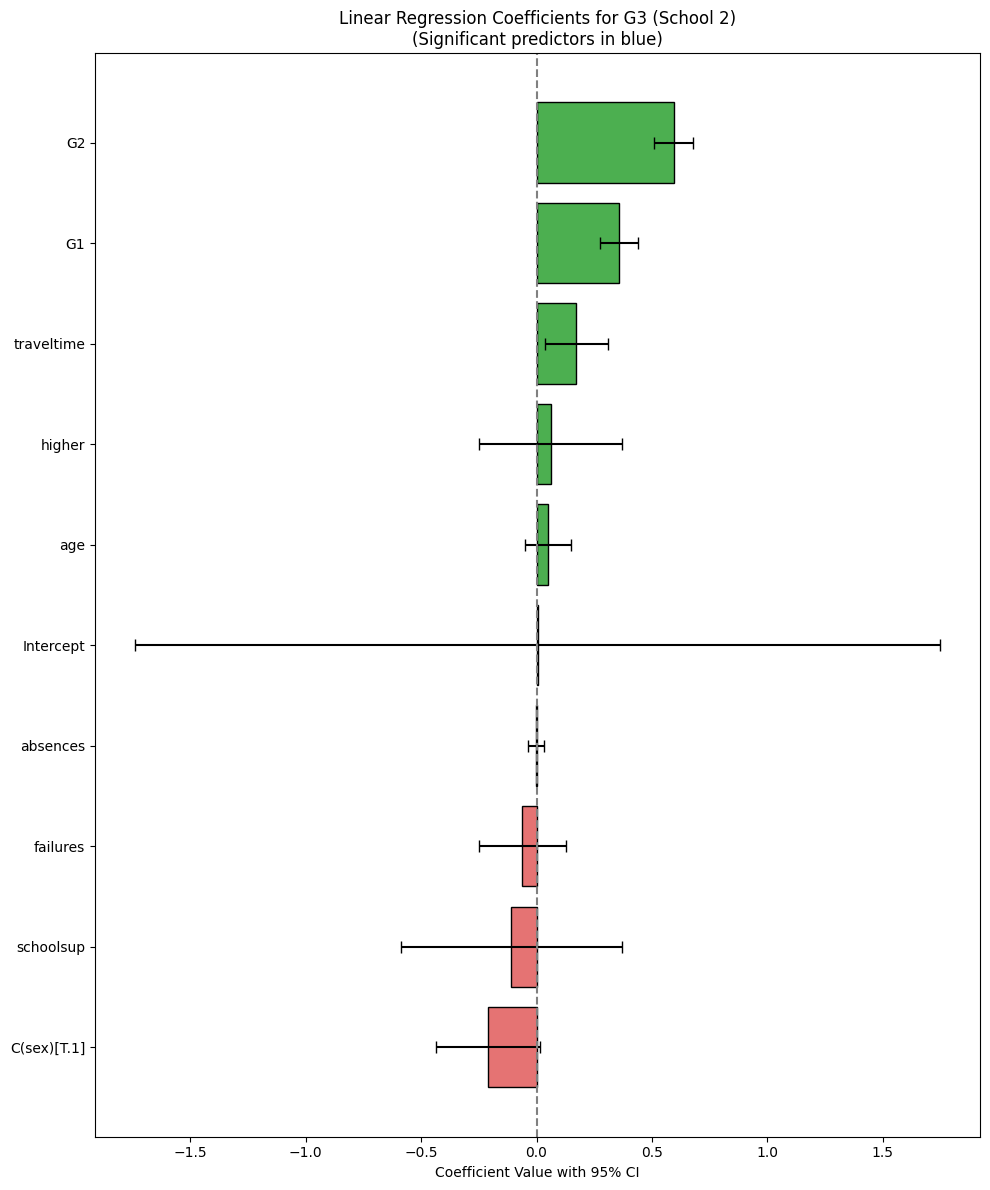

Observed Frequencies:
 sex       0    1
school          
0       139   73
1       237  184 



/usr/local/lib/python3.12/dist-packages/statsmodels/graphics/mosaicplot.py:651: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rect = Rectangle((x, y), w, h, label=text, **props)


<Figure size 1000x600 with 0 Axes>

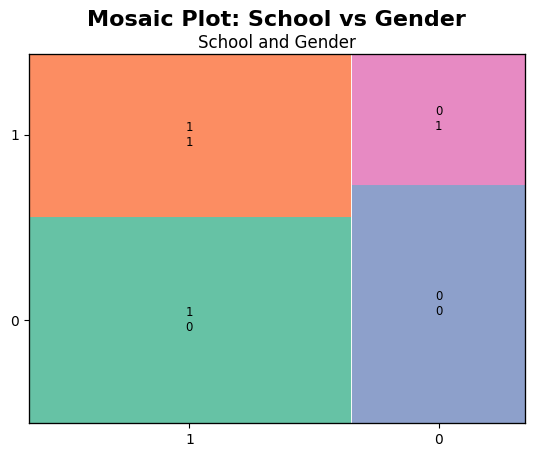

In [9]:

#Extra analysis
# The models were ran separately for both schools independently with these predictors.
# Sex difference between two schools were observed.

# School 1:
df_school1 = df_subset[(df_subset['school'] ==1)]
print(df_school1.shape)
print(df_school1.columns.tolist())
summerize = df_school1.describe()
print(summerize)

categorical_vars = ['sex']
continuous_vars = ['G1', 'G2', 'age', 'traveltime', 'failures', 'absences', 'higher', 'schoolsup', ]

formula = 'G3 ~ ' + ' + '.join(continuous_vars + [f'C({var})' for var in categorical_vars])
print("Model formula:", formula)

model1 = smf.ols(formula=formula, data=df_school1).fit()
print(model1.summary())

# Coefficients with 95% confidence intervals
conf_int = model1.conf_int()
conf_int.columns = ['CI_lower', 'CI_upper']
coef_df_school1 = conf_int.copy()
coef_df_school1['coef'] = model1.params
coef_df_school1 = coef_df_school1.sort_values(by='coef', ascending=False)
print("\nCoefficients with 95% CI:")
print(coef_df_school1)
# Model performance metrics
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model1.predict(df_school1)
y = df_school1['G3']
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.3f}")
#====================================================================

coef_df_school1_sorted = coef_df_school1.sort_values(by='coef')
colors_school1 = np.where(coef_df_school1_sorted['coef'] >= 0, '#4CAF50', '#E57373')  # green vs red

plt.figure(figsize=(10, 12))
plt.barh(
    coef_df_school1_sorted.index,
    coef_df_school1_sorted['coef'],
    xerr=[coef_df_school1_sorted['coef'] - coef_df_school1_sorted['CI_lower'], coef_df_school1_sorted['CI_upper'] - coef_df_school1_sorted['coef']],
    color=colors_school1,
    edgecolor='black',
    capsize=4
)
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value with 95% CI')
plt.title('Regression Coefficients and 95% Confidence Intervals (School 1)', fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


#=======================================


df_school2 = df_subset[(df_subset['school'] ==0)]
print(df_school2.shape)
print(df_school2.columns.tolist())
summerize = df_school2.describe()
print(summerize)

categorical_vars = ['sex']
continuous_vars = ['G1', 'G2', 'age', 'traveltime', 'failures', 'absences', 'higher', 'schoolsup', ]

formula1 = 'G3 ~ ' + ' + '.join(continuous_vars + [f'C({var})' for var in categorical_vars])
print("Model formula:", formula1)

model2 = smf.ols(formula=formula1, data=df_school2).fit()
print(model2.summary())


# Coefficients with 95% confidence intervals
conf_int = model2.conf_int()
conf_int.columns = ['CI_lower', 'CI_upper']
coef_df_school2 = conf_int.copy()
coef_df_school2['coef'] = model2.params
coef_df_school2 = coef_df_school2.sort_values(by='coef', ascending=False)
print("\nCoefficients with 95% CI:")
print(coef_df_school2)
# Model performance metrics
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model2.predict(df_school2)
y = df_school2['G3']
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.3f}")

coef_df_school2_sorted = coef_df_school2.sort_values(by='coef')
colors_school2 = np.where(coef_df_school2_sorted['coef'] >= 0, '#4CAF50', '#E57373')  # green vs red

plt.figure(figsize=(10, 12))
plt.barh(coef_df_school2_sorted.index, coef_df_school2_sorted['coef'],
         xerr=[coef_df_school2_sorted['coef'] - coef_df_school2_sorted['CI_lower'], coef_df_school2_sorted['CI_upper'] - coef_df_school2_sorted['coef']],
         color=colors_school2, edgecolor='black', capsize=4)
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value with 95% CI')
plt.title('Linear Regression Coefficients for G3 (School 2)\n(Significant predictors in blue)')
plt.tight_layout()
plt.show()

#========================================================
# Create contingency table
table = pd.crosstab(df_subset['school'], df_subset['sex'])
print("Observed Frequencies:\n", table, "\n")
import seaborn as sns
# Create a color palette for categories
colors = {
    ('1', '0'): sns.color_palette("Set2")[0],
    ('1', '1'): sns.color_palette("Set2")[1],
    ('0', '0'): sns.color_palette("Set2")[2],
    ('0', '1'): sns.color_palette("Set2")[3],
}
# Plot
plt.figure(figsize=(10,6))
mosaic(student_df, ['school', 'sex'],
       properties=lambda key: {'color': colors.get(key, 'lightgray'),
                               'edgecolor': 'white', 'linewidth': 1.5})
plt.title("Mosaic Plot: School vs Gender", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("School and Gender", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)
plt.show()